In [15]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
import statistics 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP
from joblib import dump, load
from itertools import chain
from typing import Union, Any
from collections import Counter

from sklearn import preprocessing,svm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize

# Non-linear classifiers
from sklearn import svm # Should do with RBF or polynomial kernel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier 
# Note OVR -- sensitive to imbalanced dataset, OVO is less sensitive
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from utils.common import *
from utils.dataset import CS4220Dataset
from utils.feature_selection import *
from utils.model_evaluation import *

import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

import umap.plot
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [3]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

def create_label_df(df):
    # This is required for dataset function
    le = preprocessing.LabelEncoder()
    le.fit(df['species_name'].unique())
    y_index = le.transform(df['species_name'].values)
    df['labels'] = y_index
    print(f"Unique labels {len(df['species_name'].unique())}")

    return df, le

def create_sampling_idx(df, sample_num:int, replace:bool=False, random_state:int=40):
    return df.groupby('labels').sample(sample_num, replace=replace,random_state =random_state).index

def create_new_dataset(labels:pd.DataFrame, dateset:Union[pd.DataFrame, np.array], filtered:Union[str,list], sample_num:Union[int,None]):
    if isinstance(filtered, str):
        filter_idx = labels[labels.species_name != filtered].index
        print(f" filtered for {filtered} : {labels.iloc[labels[labels.species_name != filtered].index].species_name.unique()}")
        final_labels = labels.copy().iloc[filter_idx][["species_name"]]
        # Create new label_df 
        label_df, le = create_label_df(final_labels)
        final_dataset = dateset.copy().iloc[filter_idx]

        # If sample_num
        if sample_num:
            samples_index = create_sampling_idx(df = label_df, sample_num=sample_num)
            return pd.concat([label_df,final_dataset], axis=1).iloc[samples_index], le

        return pd.concat([label_df,final_dataset], axis=1), le
        
def filtered_array(array, idx_to_keep):
    return np.take(array, idx_to_keep, axis=1)
  
def get_all_jaccard_index_with_filter( model:Any, label_encoder:Any , filtered_idx:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data = filtered_array(df_test,filtered_idx)
        print(f"Shape of {transformed_data.shape}")
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))

        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)

    return all_jaccard_index, flatten(all_pred), flatten(all_true)    

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def random_forest_selector(X,y):
    # Using feature importance to select features
    model = RandomForestClassifier(random_state=1, max_depth=10)
    model.fit(X,y)
    features = X.columns
    importances = model.feature_importances_
    # Create a dataframe for feature importance
    feature_importance_df = pd.DataFrame({"features": list(features) ,"importances": list(importances)} )
    indices = np.argsort(importances)[-9:]  # top 10 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

    return feature_importance_df

def create_coarse_labels(df):
    df['coarse_species_name'] = np.where(df['species_name'] != "decoy", "non_decoy", "decoy")
    le = preprocessing.LabelEncoder()
    le.fit(df['coarse_species_name'].unique())
    y_index = le.transform(df['coarse_species_name'].values)
    df['labels'] = y_index
    print(f"Unique labels {len(df['coarse_species_name'].unique())}")
    return df, le

def jaccard_index_per_patient(patient_id:str, preds):
    # Generic filename
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp) , preds, df_true['labels'].values

def get_all_jaccard_index_with_transformation( model:Any, label_encoder:Any , x_transformer:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data =x_transformer.fit_transform(df_test)
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))
        
        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        print(f"final_predictions {final_predictions} , unique {np.unique(final_predictions)}")
        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)

    return all_jaccard_index, flatten(all_pred), flatten(all_true)

def flatten(original_list:list):
    return list(chain.from_iterable(original_list))

def get_kmer_analysis_map(dataset):
    test = dataset.X_mapped.copy()
    test["labels"] = dataset.Y   
    return test.groupby("labels").mean().reset_index()
    
def getting_no_kmer_existence(analysis):

    kmer_by_label = dict()
    # Obtaining the profile
    for elem in analysis.index:
        kmer_by_label[elem] = analysis.iloc[elem,1:-1]

    # Getting label without that kmer
    for elem in analysis.index:
        kmer_zero = list(kmer_by_label[elem][kmer_by_label[elem]==0].index)
        if (len(kmer_zero) > 0):
            print(f" label {elem} ::  {kmer_zero}")

    return kmer_zero

def get_label_by_kmer(kmer_analysis):
    label_profile_by_kmer = dict()

    # Obtaining the profile
    for elem in range(1,len(kmer_analysis.columns)-1):
        label_profile_by_kmer[kmer_analysis.columns[elem]] = kmer_analysis.iloc[:,elem]
    return label_profile_by_kmer

def get_std_across_labels_by_kmer(kmer_analysis):
    label_profile_by_kmer = get_label_by_kmer(kmer_analysis)

    std_accross_labels = dict()

    for key, values in label_profile_by_kmer.items():
        std_accross_labels[key] = np.std(values)

    # Sort by variation
    std_accross_labels_sorted = dict(sorted(std_accross_labels.items(), key=lambda item: item[1]))

    return std_accross_labels_sorted

def get_label_map(label_encoder):
    return dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

## Creating Dataset for model ablation study

In [5]:
label_df = pd.read_csv('./training_data/train_labels.csv')
get_species_count(label_df)

# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
processed_label_df ,label_encoder = create_label_df(label_df)
#this label_df will have label index instead of the actual class value

samples_400_index = create_sampling_idx(label_df,replace=True, sample_num=400,random_state=1)

# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(
    data_file=input_file_path, label_df=processed_label_df, samples_index=samples_400_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

Unique labels 26
10400 2080
10400


In [7]:
# Train test split to test the different models
X_train_fine, X_test_fine, y_train_fine, y_test_fine = train_test_split(sampled_dataset.X, sampled_dataset.Y,
                                                    test_size=0.1)

## SVC

In [17]:
parameters = {'C':[1, 10]}
svc = svm.SVC(decision_function_shape="ovr", kernel="rbf",probability=True)
clf = GridSearchCV(svc, parameters, scoring = 'f1',cv=2, n_jobs=-1,verbose=1)
clf.fit(X_train_fine, y_train_fine)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1, 10]}, verbose=1)

best model SVC(C=10, probability=True)


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


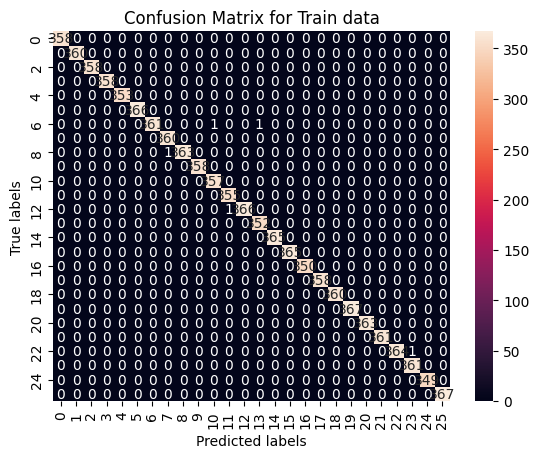

 Macro Precision :  0.95, Recall :  0.95, F1 :  0.95
 Micro Precision :  0.95, Recall :  0.95, F1 :  0.95


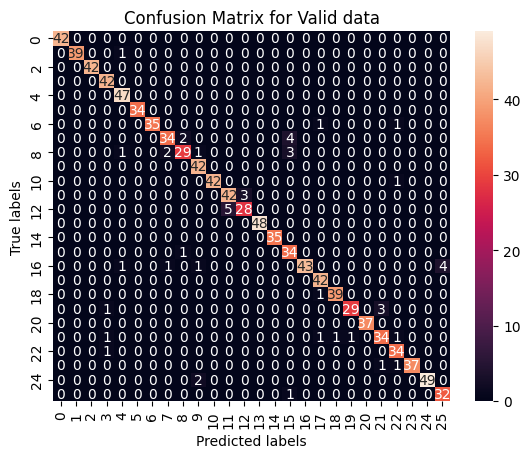

In [18]:
model_name = "svc_400_model_type"
# Train the model using the training sets
print(f"best model {clf.best_estimator_}")
dump( clf.best_estimator_,f'models/{model_name}.joblib')

# Max dept == 10, sample 750
performance_evaluate(
    train_dataset=(X_train_fine, y_train_fine),
    valid_dataset=(X_test_fine, y_test_fine),
    model_name=model_name,
    filepath="models"
)

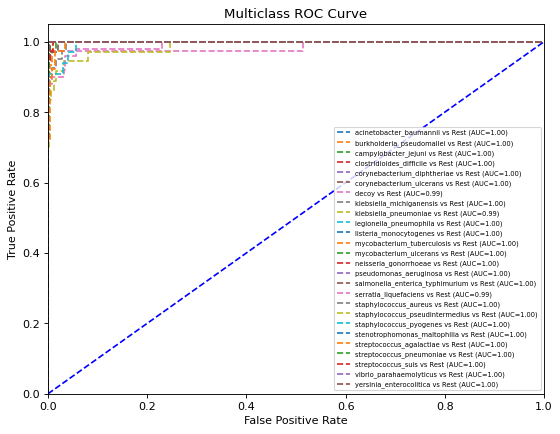

[           inf 9.97469376e-01 6.99733429e-01 6.68315596e-01
 5.81428737e-01 5.76148167e-01 2.38194952e-01 2.36101456e-01
 6.54105172e-03 6.43294858e-03 2.33555605e-03 2.31521327e-03
 1.91966907e-03 1.89473552e-03 1.45509710e-03 1.43450726e-03
 4.79171165e-04 4.77811709e-04 3.20996458e-04 3.19980697e-04
 2.64400436e-04 2.64158545e-04 1.65204149e-05 1.63125040e-05
 3.14858110e-06] [0.         0.03030303 0.93939394 0.93939394 0.96969697 0.96969697
 0.96969697 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ] [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.93048659e-04
 9.93048659e-04 2.97914598e-03 3.97219464e-03 3.97219464e-03
 9.73187686e-02 9.93048659e-02 2.02581927e-01 2.04568024e-01
 2.35352532e-01 2.37338630e-01 2.84011917e-01 2.85998014e-01
 4.96524330e-01 4.98510427e-01 5.86891758e-01 5.88877855e-01
 6.23634558e-01 6.25620655e-01 9.65243297e-01 9.6722939

In [21]:
# Plot ROC
figure(figsize=(8, 6), dpi=80)
y_pred =clf.best_estimator_.predict(X_test_fine)
pred_prob = clf.best_estimator_.predict_proba(X_test_fine)

y_test_binarized=label_binarize(y_test_fine,classes=np.unique(y_test_fine))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = label_encoder.classes_.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(label_encoder.classes_[i],roc_auc[i]))
plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
fpr, tpr, thresholds = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=6)
plt.show()

print(thresholds, tpr, fpr)

## Random Forest Estimator

Fitting 2 folds for each of 4 candidates, totalling 8 fits
best model RandomForestClassifier(max_depth=16, n_estimators=300)
 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


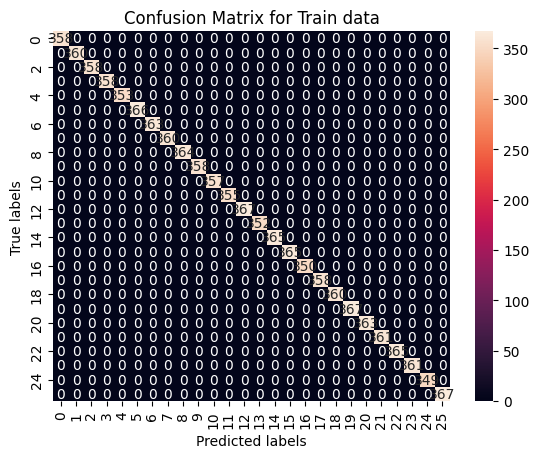

 Macro Precision :  0.88, Recall :  0.88, F1 :  0.87
 Micro Precision :  0.88, Recall :  0.88, F1 :  0.88


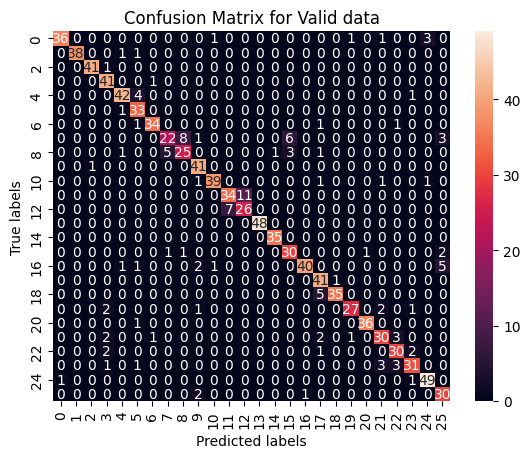

In [24]:
model_name = "rf_400_model_type"
# feature impt set 
param_grid = {
    'n_estimators': [300,250],
    'max_depth': [14,16]
}
starting_time = timeit.default_timer()

gridmodel =GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'f1',cv=2, n_jobs=-1,verbose=1)
gridmodel.fit(X_train_fine, y_train_fine)
%timeit

# Train the model using the training sets
print(f"best model {gridmodel.best_estimator_}")
dump( gridmodel.best_estimator_,f'models/{model_name}.joblib')

# Max dept == 10, sample 750
performance_evaluate(
    train_dataset=(X_train_fine, y_train_fine),
    valid_dataset=(X_test_fine, y_test_fine),
    model_name=model_name,
    filepath="models"
)

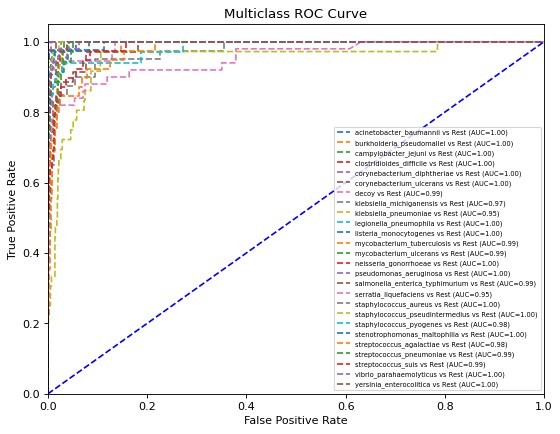

[           inf 8.56160809e-01 2.40698548e-01 2.39018689e-01
 2.28305044e-01 2.17681771e-01 2.05027151e-01 1.88496324e-01
 1.68735752e-01 1.29089674e-01 1.25603829e-01 1.14047883e-01
 1.12521653e-01 9.39706057e-02 9.38821945e-02 8.89107143e-02
 8.82399942e-02 6.12408485e-02 6.11716195e-02 2.67230297e-02
 2.66666667e-02 2.64672755e-02 2.64539988e-02 2.34007096e-02
 2.33333333e-02 1.67113956e-02 1.66666667e-02 1.61673471e-02
 1.61246970e-02 1.35285328e-02 1.33333333e-02 1.05794428e-02
 1.05539865e-02 1.04362657e-02 1.03703704e-02 1.01075269e-02
 1.00000000e-02 8.06186239e-03 8.00000000e-03 7.04791612e-03
 6.98924731e-03 6.69856053e-03 6.66666667e-03 4.85844745e-03
 4.84126984e-03 4.06318567e-03 4.00000000e-03 3.36036876e-03
 3.33333333e-03 1.83992846e-03 1.66666667e-03 1.32965494e-03
 1.28571429e-03 1.11240310e-03 9.65309201e-04 8.53116568e-04
 8.33333333e-04 5.59649123e-04 5.55555556e-04 4.49484474e-04
 3.70370370e-04 3.57142857e-04 3.33333333e-04 1.85185185e-04
 1.75438596e-04 1.587301

In [25]:
# Plot ROC
figure(figsize=(8, 6), dpi=80)
y_pred =gridmodel.best_estimator_.predict(X_test_fine)
pred_prob = gridmodel.best_estimator_.predict_proba(X_test_fine)

y_test_binarized=label_binarize(y_test_fine,classes=np.unique(y_test_fine))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = label_encoder.classes_.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(label_encoder.classes_[i],roc_auc[i]))
plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
fpr, tpr, thresholds = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=6)
plt.show()

print(thresholds, tpr, fpr)

## Logistic Regression

In [27]:
# multi_class{‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
model_name = "lr_400_model_type"
#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'f1_weighted',
                              cv = 2,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(X_train_fine, y_train_fine)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

# Train the model using the training sets
print(f"best model {grid_search_lr.best_estimator_}")
dump( grid_search_lr.best_estimator_,f'models/{model_name}.joblib')

# Max dept == 10, sample 750
performance_evaluate(
    train_dataset=(X_train_fine, y_train_fine),
    valid_dataset=(X_test_fine, y_test_fine),
    model_name=model_name,
    filepath="models"
)

Epoch 32, change: 0.02058337


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 33, change: 0.01998141
Epoch 2, change: 0.33721523
Epoch 1, change: 1.00000000
Epoch 2, change: 0.25883147
Epoch 2, change: 0.30686965
Epoch 2, change: 0.29107012
Epoch 2, change: 0.33826951
Epoch 2, change: 0.29236277
Epoch 3, change: 0.14471883
Epoch 3, change: 0.19884839
Epoch 3, change: 0.12157964
Epoch 3, change: 0.21233159
Epoch 2, change: 0.29517121
Epoch 3, change: 0.14395653
Epoch 4, change: 0.17075150
Epoch 2, change: 0.34076987
Epoch 4, change: 0.10122663
Epoch 4, change: 0.13525008
Epoch 3, change: 0.21439927
Epoch 4, change: 0.12993758
Epoch 34, change: 0.01954285
Epoch 5, change: 0.11616738
Epoch 5, change: 0.08193289
Epoch 5, change: 0.08229049
Epoch 5, change: 0.10985041
Epoch 4, change: 0.17449738
Epoch 4, change: 0.13151620
Epoch 3, change: 0.21443381
Epoch 6, change: 0

KeyboardInterrupt: 

Epoch 42, change: 0.01661201


In [ ]:
# Plot ROC
figure(figsize=(8, 6), dpi=80)
y_pred =grid_search_lr.best_estimator_.predict(X_test_fine)
pred_prob = grid_search_lr.best_estimator_.predict_proba(X_test_fine)

y_test_binarized=label_binarize(y_test_fine,classes=np.unique(y_test_fine))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = label_encoder.classes_.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(label_encoder.classes_[i],roc_auc[i]))
plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
fpr, tpr, thresholds = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=6)
plt.show()

print(thresholds, tpr, fpr)